In [1]:
# Importing the required libraries
import numpy as np
import cv2
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import time
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import json

In [2]:
def kernel_density_estimation(image):
    
    start_time = time.time()
    
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute the kernel density estimate of the pixel values
    kde = gaussian_kde(gray.flatten())

    # Evaluate the KDE at each pixel value
    pdf = kde(gray.flatten())

    # Reshape the PDF to the original image size
    pdf = np.reshape(pdf, gray.shape)

    # Threshold the PDF to create a mask of the foreground
    mask = np.uint8(pdf < np.max(pdf) * 0.2)

    # Apply the mask to the original image to get the foreground
    foreground = cv2.bitwise_and(gray, gray, mask=mask)
    ret, thresh1 = cv2.threshold(foreground, 50, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Resizing the image to desired dimension and again apply Threshold
    resize_image = cv2.resize(thresh1, [50,50], interpolation = cv2.INTER_AREA)
    ret, thresh2 = cv2.threshold(resize_image, 150, 255, cv2.THRESH_BINARY)

    return cv2.merge([thresh2, thresh2, thresh2]), (time.time() - start_time)

In [3]:
def convex_hull(image):
    
    start_time = time.time()
    
    # Applying Gaussian blur
    blur = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Changing color-space from BGR -> HSV
    hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)

    # Creating a binary image with where white will be skin colors and rest is black
    mask2 = cv2.inRange(hsv, np.array([2, 0, 0]), np.array([20, 255, 255]))

    # Kernel for morphological transformation
    kernel = np.ones((5, 5))

    # Applying morphological transformations to filter out the background noise
    dilation = cv2.dilate(mask2, kernel, iterations=1)
    erosion = cv2.erode(dilation, kernel, iterations=1)

    # Applying Gaussian Blur and Threshold
    filtered = cv2.GaussianBlur(erosion, (3, 3), 0)
    ret, thresh = cv2.threshold(filtered, 75, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Resizing the image to desired dimension and again apply Threshold
    resize_image = cv2.resize(thresh, [50,50], interpolation = cv2.INTER_AREA)
    ret2, thresh2 = cv2.threshold(resize_image, 60, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    return cv2.merge([thresh2, thresh2, thresh2]), (time.time() - start_time)

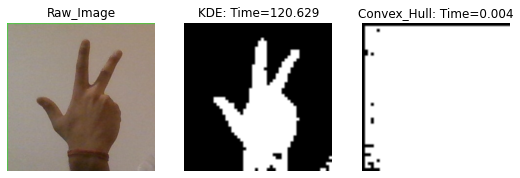

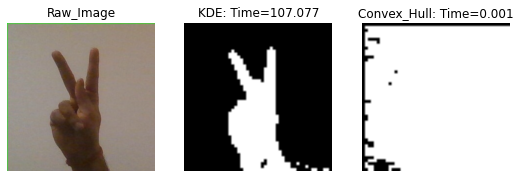

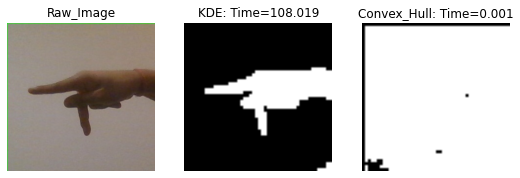

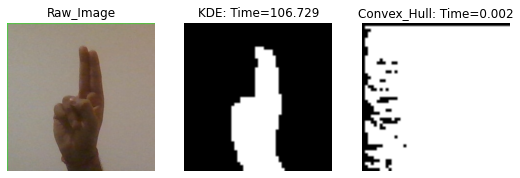

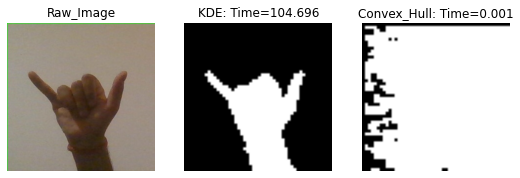

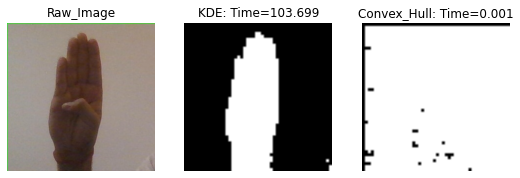

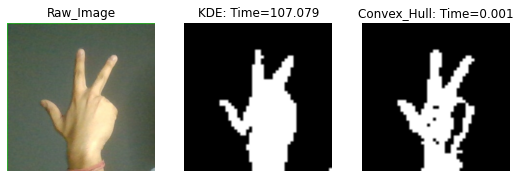

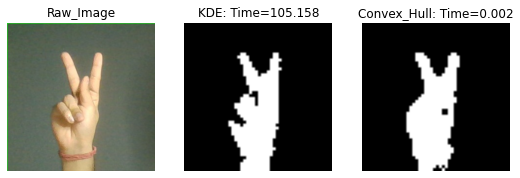

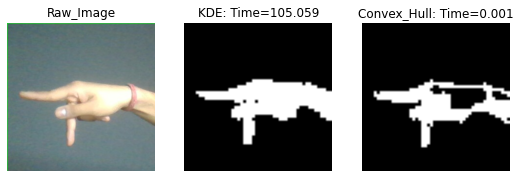

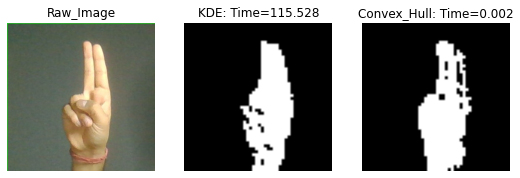

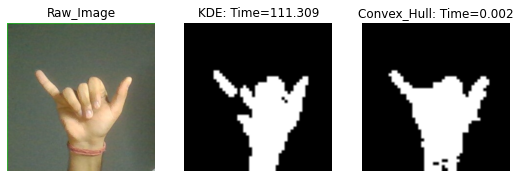

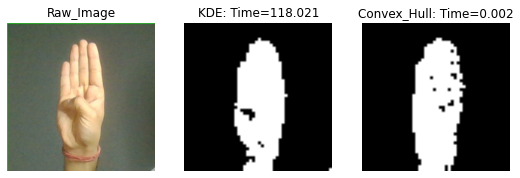

Average KDE time =  109.417
Average Convex Hull time =  0.002


In [4]:
kde_time = 0
ch_time = 0

for i in range(1,13):
    img = cv2.imread(f'./test/{i}.jpg')
    
    # Kernel Density Estimation
    kde, eta1 = kernel_density_estimation(img)
    kde = img_to_array(kde)
    kde = kde/255
    kde_time = kde_time + eta1
    
    # Convex Hull method
    ch, eta2 = convex_hull(img)
    ch = img_to_array(ch)
    ch = ch/255
    ch_time = ch_time + eta2

    # Displaying the results
    fig, axs = plt.subplots(1, 3, figsize=(9,3.5))
    ax=axs[0].axis("off")
    ax=axs[0].set_title('Raw_Image')
    ax=axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax=axs[1].axis("off")
    ax=axs[1].set_title(f'KDE: Time={round(eta1, 3)}')
    ax=axs[1].imshow(cv2.cvtColor(kde, cv2.COLOR_BGR2RGB))
    ax=axs[2].axis("off")
    ax=axs[2].set_title(f'Convex_Hull: Time={round(eta2, 3)}')
    ax=axs[2].imshow(cv2.cvtColor(ch, cv2.COLOR_BGR2RGB))
    plt.show()
    
# Calculating the average time taken by each method
print('Average KDE time = ', round(kde_time/i, 3))
print('Average Convex Hull time = ', round(ch_time/i, 3))